## PROJENİN ÖZETİ

Bu projede dataset **imbalanced** olduğundan **upsampling** yöntemi ile frekansı az olan sınıf diğer sınıf oranında arttırılmıştır.

ilk model olarak **LightGBM** modeli kurulmuştur. Bu model sonucunda alınan en iyi hyperparametre sonuçları ile XGBOOST modeli kurulmuştur. 

**Accuracy : 0.87**

İkinci model için **Logistic Regresyon** kullanılmıştır.

**Accuracy : 0.85**

İki model kıyaslandığında recall ve accuracy değerleri Logistic Regresyondan daha iyi olan **XGBOOST modeli ile proje devam etmelidir.**


## VERİYE İLK BAKIŞ

In [261]:
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
from pandas.io.json import json_normalize
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score

In [262]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [202]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [203]:
#2.1
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [263]:
df0=pd.read_csv("/content/drive/MyDrive/term-deposit-marketing-2020.csv") 

In [264]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [265]:
df=df0.copy()

In [266]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [267]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

## LABEL ENCODER

In [268]:
#label encoder
#binary : housing, loan, default, y
from sklearn import preprocessing 
lbe= preprocessing.LabelEncoder()

In [269]:
df["housing"]= lbe.fit_transform(df["housing"])
df["loan"]= lbe.fit_transform(df["loan"])
df["default"]= lbe.fit_transform(df["default"])
df["y"]= lbe.fit_transform(df["y"])

In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  int64 
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  int64 
 7   loan       40000 non-null  int64 
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 4.3+ MB


## DEĞİŞKENLERİN FREKANSLARININ İNCELENMESİ

In [254]:
df['job'].value_counts()

KeyError: ignored

In [213]:
#imbalanced data
df['y'].value_counts() 

0    37104
1     2896
Name: y, dtype: int64

In [132]:
df['marital'].value_counts()

married     24386
single      10889
divorced     4725
Name: marital, dtype: int64

In [ ]:
df['education'].value_counts()

secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: education, dtype: int64

In [ ]:
df['contact'].value_counts()

cellular     24914
unknown      12765
telephone     2321
Name: contact, dtype: int64

In [ ]:
df['month'].value_counts()

may    13532
jul     6380
aug     5215
jun     4734
nov     3598
apr     2718
feb     2296
jan     1176
mar      258
oct       80
dec       13
Name: month, dtype: int64

## ORDİNAL DEĞİŞKENLERİN LABEL ENCODING YAPILMASI

In [271]:
#label encoding with ordinal variable
categories=pd.Categorical(df['education'],categories=['unknown','primary','secondary','tertiary'],ordered=True)
print(categories)


['tertiary', 'secondary', 'secondary', 'unknown', 'unknown', ..., 'tertiary', 'tertiary', 'secondary', 'tertiary', 'secondary']
Length: 40000
Categories (4, object): ['unknown' < 'primary' < 'secondary' < 'tertiary']


In [272]:
education,unique=pd.factorize(categories,sort=True)
df['education']=education

In [273]:
df['education'].value_counts()

2    20993
3    11206
1     6270
0     1531
Name: education, dtype: int64

In [274]:
categories=pd.Categorical(df['month'],categories=['jan','feb','mar','apr','may','jun', 'jul', 'aug', 'oct', 'nov', 
                                                  'dec'],ordered=True)
print(categories)

['may', 'may', 'may', 'may', 'may', ..., 'jun', 'jun', 'jun', 'jun', 'jun']
Length: 40000
Categories (11, object): ['jan' < 'feb' < 'mar' < 'apr' ... 'aug' < 'oct' < 'nov' < 'dec']


In [275]:
month,unique=pd.factorize(categories,sort=True)
df['month']=month

In [276]:
df['month'].value_counts()

4     13532
6      6380
7      5215
5      4734
9      3598
3      2718
1      2296
0      1176
2       258
8        80
10       13
Name: month, dtype: int64

## ONE HOT ENCODING

In [277]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  int64 
 4   default    40000 non-null  int64 
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  int64 
 7   loan       40000 non-null  int64 
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  int64 
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  int64 
dtypes: int64(11), object(3)
memory usage: 4.3+ MB


In [278]:
df.month.value_counts()

4     13532
6      6380
7      5215
5      4734
9      3598
3      2718
1      2296
0      1176
2       258
8        80
10       13
Name: month, dtype: int64

## NOMINAL ONE HOT ENCODER

In [279]:
#job
#marital
#contact

nominal_cols= ["job", "marital", "contact"]
for i in nominal_cols:
    df = pd.get_dummies(df, columns=[i], prefix=[i])

## CORRELATION MATRIX

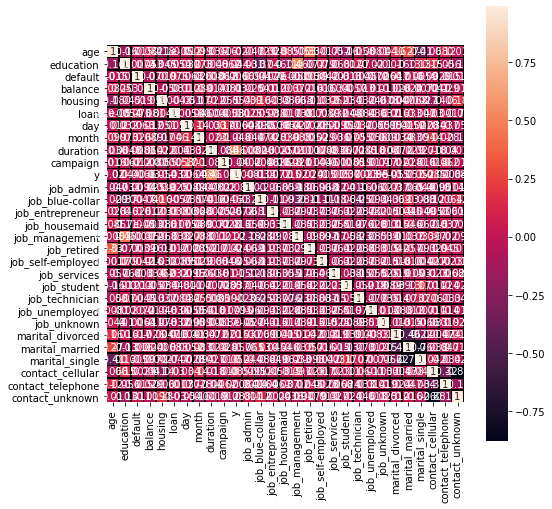

In [84]:
corr=df.corr()
plt.figure(figsize=(8, 8))
a=sns.heatmap(corr, vmax=.99, linewidths=0.5,square=True,annot=True,linecolor="black");

## TARGET BELİRLEME / SPLIT 
Dataset split edilirken train %70, validation %20 ve test %10 alınmıştır

In [280]:
y=df['y']
X=df.drop(['y'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=1)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.20, random_state=1)

In [281]:
X_train.shape

(28800, 28)

In [282]:
X_test.shape

(4000, 28)

## Upsampling

In [283]:
def upsample(X_train, y_train):
    df_all = pd.concat((X_train, pd.DataFrame({'value': y_train}, index=y_train.index)), axis=1)
    
    df_majority = df_all [df_all.value==0]
    df_minority = df_all[df_all.value==1]
     
    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=df_majority.shape[0],    # to match majority class
                                     random_state=123) # reproducible results
    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled], axis=0)
    y_upsampled = df_upsampled.value
    X_upsampled = df_upsampled.drop('value', axis=1)

    return X_upsampled, y_upsampled


In [284]:
from sklearn.utils import resample
X_train,y_train=upsample(X_train, y_train)

## Light GBM Parametre Tuning

1.   Parametre tuning yapılmıştır. Ardından xgboost modeli kurulacaktır



In [285]:
#model kurma
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()
import lightgbm as lgb

lgbm = LGBMClassifier().fit(X_train, y_train)
#Model Tuning
lgbm_params = {"colsample_bytree":[0.4,0.5,1],"learning_rate":[0.01,0.1,0.5], "max_depth": [5,10,50,100], 
               "n_estimators": [40,100,200,1000]}
lgbm_cv = GridSearchCV(lgbm, lgbm_params, cv=5, n_jobs=-1, verbose=2)
lgbm_cv.fit(X_valid, y_valid)
lgbm_cv.best_params_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  4.1min finished


{'colsample_bytree': 0.4,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 100}

## *XGBOOST*



2.   Lightgbm modelinde en iyi çıkan hyperparametre değerleri ile XGboost modeli kurulmuştur



In [286]:
last_model = xgb.XGBClassifier(boosting_type= 'gbdt',
    objective= 'binary:logistic',
    metric= ['mae'],
    num_leaves= 64,
    max_depth=5,
    learning_rate= 0.1,
    bagging_fraction= 0.6,
    bagging_freq= 3,
    min_data_in_leaf = 50,
    n_estimators=100, colsample_bytree=0.4)

In [287]:
last_model.fit(X_train, y_train)

XGBClassifier(bagging_fraction=0.6, bagging_freq=3, base_score=0.5,
              booster='gbtree', boosting_type='gbdt', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5, metric=['mae'],
              min_child_weight=1, min_data_in_leaf=50, missing=None,
              n_estimators=100, n_jobs=1, nthread=None, num_leaves=64,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [288]:
X_train.shape

(53404, 28)

In [289]:
xgb_pred =last_model.predict(X_test)

In [290]:
from sklearn.metrics import accuracy_score
#accuracy
accuracy = accuracy_score(y_test, xgb_pred)
accuracy

0.884

In [291]:
confusion_matrix(y_test, xgb_pred)

array([[3268,  422],
       [  42,  268]])

In [292]:
from sklearn.metrics import classification_report
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.99      0.89      0.93      3690
           1       0.39      0.86      0.54       310

    accuracy                           0.88      4000
   macro avg       0.69      0.88      0.73      4000
weighted avg       0.94      0.88      0.90      4000



## Feature Importance
Modeli etkileyen 15 önemli değişken incelenmiştir

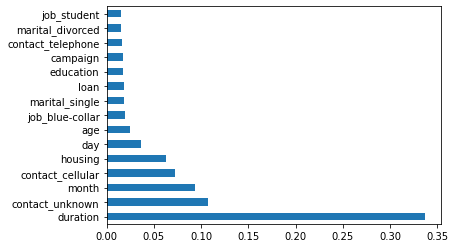

In [294]:
feature_imp = pd.Series(last_model.feature_importances_, index= X_train.columns)
feature_imp.nlargest(15).plot(kind='barh');

## LOGISTIC REGRESSION
Bu projede ikinci model olarak logistic regression kullanılmıştır

In [295]:
from sklearn.linear_model import LogisticRegression

In [296]:
from sklearn.linear_model import LogisticRegressionCV
log_model_cv = LogisticRegressionCV(cv=5, random_state=0).fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [297]:
y_pred = log_model_cv.predict(X_test)

In [298]:
#confusion_matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[3174,  516],
       [  63,  247]])

In [299]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92      3690
           1       0.32      0.80      0.46       310

    accuracy                           0.86      4000
   macro avg       0.65      0.83      0.69      4000
weighted avg       0.93      0.86      0.88      4000



In [300]:
accuracy_score(y_test, y_pred)

0.85525